<a href="https://colab.research.google.com/github/sfbllgrn/DD2412_Class_Contrastive_Explanations/blob/main/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google drive that contains all data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports
from torchvision.models import densenet161, DenseNet161_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import mnasnet0_5, MNASNet0_5_Weights # Här gissar jag att dom använder 0.5, står inte någonstans
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

import numpy as np
import torch
from torch.autograd.functional import jacobian as J
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import sys
from torchvision import transforms
from torch import nn
from torch.nn.functional import one_hot

from datetime import datetime
import json
import os
from math import ceil



In [3]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# Load data

# when data is stored locally
#data_folder = "/Users/sofia/Documents/Skola/KTH/Master/Deep Learning, Advanced Course DD2412/Class Contrastive Explanations/DD2412_Class_Contrastive_Explanations/Data_small"

# for data stored on google drive
data_folder = "/content/drive/MyDrive/Colab Notebooks/Deep learning advanced/ImageNet_Data/val"
data_obj = ImageFolder(root=data_folder, transform=DenseNet161_Weights.DEFAULT.transforms())

BATCH_SIZE = 64
val_dataloader = DataLoader(data_obj, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

split_point = len(data_obj)//2
sub_dataloader1 = DataLoader(data_obj[0:split_point],batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
sub_dataloader2 = DataLoader(data_obj[split_point:],batch_size=BATCH_SIZE, shuffle=False, num_workers=1)


In [5]:
# Init Pretrained models

# debug:
alex = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
pretrained_models = {"alexnet":alex}

#densenet = densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)
#mobilenet_small = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#alex = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
#google = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
#mnasnet = mnasnet0_5(weights=MNASNet0_5_Weights.IMAGENET1K_V1)
#resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#mobilenet_large = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)  # Denna har även IMAGENET1K_v2
#efficientnet = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1) # Denna har även IMAGENET1K_v2
#pretrained_models = {
 #                    "alexnet":alex, "googlenet":google,
 #                    "mnasnet":mnasnet, "resnet":resnet,
 #                    "mobilenet_large":mobilenet_large,
 #                    "efficientnet":efficientnet,
 #                    "densenet":densenet, "mobilenet_small":mobilenet_small}

In [6]:
# Perform gradient sign pertubations

def calculate_weighted_contrast(x, t, net):
  """Calculated weighted attribute explanation.
  Inputs:
    - X: one tensor input data (image), with shape (1,3,224,224)
    - t: one-dimensional tensor containing target class for the input img
    - net: network model"""

  logits = net(x)
  num_classes = logits.shape[1]
  phi_t = calculate_gradient(x, t, net)

  weighted_explanation = phi_t
  alpha_denominator = torch.sum(torch.exp(logits), dim=1)-torch.exp(logits[0,t])
  check_alpha_sum = 0
  for s in range(num_classes):
    if s!=t:
      alpha_s = torch.exp(logits[0,s])/alpha_denominator
      check_alpha_sum += alpha_s  # this can be checked if it sums to 1, for debug
      s = torch.tensor([s]).to(device)
      phi_s = calculate_gradient(x, s, net)
      weighted_explanation -= alpha_s*phi_s

  return weighted_explanation


def calculate_mean_contrast(x, t, net):
    logits = net(x)
    num_classes = logits.shape[1]
    phi_t = calculate_gradient(x,t,net)
    mean_contrast = phi_t
    for s in range(num_classes):
      if s!=t:
        s = torch.tensor([s]).to(device)    # put the index s in a tensor of the same type/shape as target tensor t
        phi_s = calculate_gradient(x,s,net)
        mean_contrast -= phi_s/(num_classes-1)

    return mean_contrast


def calculate_max_contrast(x, t, net):
  logits = net(x)
  num_classes = logits.shape[1]
  if BATCH_SIZE==1:
    logits[0,t] = -100000000  # because we want to take argmax on logits except t. I assume that there will always be a logit larger than this value
  else:
    logits[torch.arange(BATCH_SIZE), t] = -100000000
  s_star = torch.argmax(logits, dim=1)
  phi_s_star = calculate_gradient(x, s_star, net)
  phi_t = calculate_gradient(x, t, net)
  return phi_t - phi_s_star


def get_attribute_explanation(x, t, net, contrast_type):
  if contrast_type=="original":
    return calculate_gradient(x, t, net)
  elif contrast_type=="weighted":
    #return calculate_weighted_contrast(x, t, net)  # weighted contrast can be calculated with regular gradient method according to prop. 2
    return calculate_gradient(x, t, net, probs=True)
  elif contrast_type=="mean":
    return calculate_mean_contrast(x, t, net)
  elif contrast_type=="max":
    return calculate_max_contrast(x, t, net)


def calculate_gradient(x, t, net, probs=False):
  logits = net(x)
  pred_probab = nn.Softmax(dim=1)(logits)
  yt_oh = one_hot(t, num_classes=logits.shape[1])
  external_grad = torch.reshape(yt_oh, logits.shape)

  x.grad = None
  if probs:
    pred_probab.backward(gradient=external_grad)
    return x.grad

  logits.backward(gradient=external_grad)
  return x.grad


def calculate_gradient_old(x, pred_indx, net, probs=False):
  if probs:
    grad = J(lambda x:nn.Softmax(dim=1)(net(x))[np.arange(BATCH_SIZE), pred_indx],x)
  else:
    grad = J(lambda x:net(x)[np.arange(BATCH_SIZE), pred_indx],x)
  grad = torch.diagonal(grad)
  grad = grad.permute(3,0,1,2)
  return grad


def gradient_sign_pertube(x, t, net, N, contrast_type="original"):
  epsilon = 1e-3
  xn = x.clone()
  saved_iterations = []
  perturbation_direction = torch.sign(get_attribute_explanation(x, t, net, contrast_type))
  clamp_lower_limit = torch.minimum(x-epsilon, torch.tensor(0))
  clamp_upper_limit = torch.maximum(x+epsilon, torch.tensor(1))
  for n in range(1,N+1):
    # I artikeln madry et al. adversarial attacks har dom originaldata här nedan
    alpha = epsilon/n
    xn = xn + alpha*perturbation_direction
    xn = torch.clamp(xn, min=clamp_lower_limit, max=clamp_upper_limit)

    if n in [1,2,10]:
      saved_iterations.append(xn.clone())

  return saved_iterations


## Test


In [ ]:
print(ceil(len(val_dataloader.dataset) / BATCH_SIZE))

N=10


model_names = ["alexnet"]

for name in model_names:
  model = pretrained_models[name].to(device)
  model.eval()

  #eval_size = len(data_obj)  # eval on all data
  n_batches = 782 #int(0.05*len(data_obj)/BATCH_SIZE)           # eval on small subset, for debug

  perturbation_types = ["original", "max", "weighted"] # skip "mean" for now, because it takes a lot of time
  accuracy_dict = {i:{p_type:0 for p_type in perturbation_types} for i in [1,2,10]}
  accuracy_unperturbed = 0
  perturbation_changes = {i:{key:{"yt":[], "pt":[]} for key in perturbation_types} for i in [1,2,10]}

  for batch_idx, (input, target) in enumerate(val_dataloader):
      if batch_idx%50 == 0:
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

      print("{} percent done".format(batch_idx*100/n_batches))


      if batch_idx < n_batches:

          input = input.to(device)
          input.requires_grad_(True)
          target = target.to(device)

          y = model(input)
          yt = y[np.arange(BATCH_SIZE), target]
          p = torch.nn.functional.softmax(y, dim=1)
          pt = p[np.arange(BATCH_SIZE), target]

          # calculate accuracy for unperturbed data
          prediction_unperturbed = torch.argmax(p, dim=1)
          for i, pred in enumerate(prediction_unperturbed):
            if pred == target[i]:
              accuracy_unperturbed += 1/(n_batches*BATCH_SIZE)

          for perturbation_type in perturbation_types:
            # perturbed x with respect to logits
            x_perturbed_list = gradient_sign_pertube(input, target, model, N, perturbation_type)

            # Disable grad to save memory, since gradient calculations are not needed in below code
            with torch.no_grad():
              for i,iter_nr in enumerate([1,2,10]):
                y_perturbed = model(x_perturbed_list[i])
                yt_perturbed = y_perturbed[np.arange(BATCH_SIZE), target]

                # Save the change in yt before and after perturbation
                perturbation_changes[iter_nr][perturbation_type]['yt'].append(yt_perturbed-yt)

                # Calculate and save change in pt before and after perturbation
                pt_perturbed = torch.nn.functional.softmax(y_perturbed, dim=1)[np.arange(BATCH_SIZE), target]
                perturbation_changes[iter_nr][perturbation_type]['pt'].append(pt_perturbed-pt)

                # Store result of perturbed prediction
                temp, prediction_perturbed = torch.max(y_perturbed, 1)
                for i,pred in enumerate(prediction_perturbed):
                  if pred == target[i]:
                    accuracy_dict[iter_nr][perturbation_type] += 1/(n_batches*BATCH_SIZE)

          torch.cuda.empty_cache()

      else:
          print(BATCH_SIZE*n_batches)
          break



782
Memory Usage:
Allocated: 0.2 GB
Cached:    0.2 GB
0.0 percent done
0.1278772378516624 percent done
0.2557544757033248 percent done
0.3836317135549872 percent done
0.5115089514066496 percent done
0.639386189258312 percent done
0.7672634271099744 percent done
0.8951406649616368 percent done
1.0230179028132993 percent done
1.1508951406649617 percent done
1.278772378516624 percent done
1.4066496163682864 percent done
1.5345268542199488 percent done
1.6624040920716112 percent done
1.7902813299232736 percent done
1.918158567774936 percent done
2.0460358056265986 percent done
2.1739130434782608 percent done
2.3017902813299234 percent done
2.4296675191815855 percent done
2.557544757033248 percent done
2.6854219948849103 percent done
2.813299232736573 percent done
2.9411764705882355 percent done
3.0690537084398977 percent done
3.1969309462915603 percent done
3.3248081841432224 percent done
3.452685421994885 percent done
3.580562659846547 percent done
3.70843989769821 percent done
3.83631713

In [55]:
def convert(obj):
    if isinstance(obj, torch.Tensor):
        return obj.cpu().numpy().tolist()
    elif isinstance(obj, dict):
        return {key: convert(value) for key, value in obj.items()}
    else:

        return obj


average_changes = {p:{str(i):{"yt":0, "pt":0, "acc":0} for i in [1,2,10]} for p in perturbation_types}
print("true accuracy", accuracy_unperturbed)
for p in perturbation_types:
  for iter_nr in [1,2,10]:
    iter_key = str(iter_nr)
    avg_pt_change = torch.mean(torch.stack(perturbation_changes[iter_nr][p]['pt']))
    avg_yt_change = torch.mean(torch.stack(perturbation_changes[iter_nr][p]['yt']))
    accuracy_change = accuracy_dict[iter_nr][p]-accuracy_unperturbed
    average_changes[p][iter_key]["pt"] = convert(avg_pt_change)
    average_changes[p][iter_key]["acc"] = convert(accuracy_change)
    average_changes[p][iter_key]["yt"] = convert(avg_yt_change)
    print("for n={} and perturbation_type={}:".format(iter_nr, p))
    print("Average changes in yt: {} and pt: {} and accuracy: {} \n".format(avg_yt_change, avg_pt_change, accuracy_change))

true accuracy 0.7234375000000061
for n=1 and perturbation_type=original:
Average changes in yt: 1.1010515689849854 and pt: 0.03266782686114311 and accuracy: 0.031250000000000444 

for n=2 and perturbation_type=original:
Average changes in yt: 1.4325259923934937 and pt: 0.04191739484667778 and accuracy: 0.03593750000000051 

for n=10 and perturbation_type=original:
Average changes in yt: 2.341381549835205 and pt: 0.06540478020906448 and accuracy: 0.05000000000000071 

for n=1 and perturbation_type=max:
Average changes in yt: 0.5134655833244324 and pt: 0.046207744628190994 and accuracy: 0.05468750000000078 

for n=2 and perturbation_type=max:
Average changes in yt: 0.6661491394042969 and pt: 0.05882427841424942 and accuracy: 0.06875000000000098 

for n=10 and perturbation_type=max:
Average changes in yt: 1.0765037536621094 and pt: 0.08993367105722427 and accuracy: 0.09062500000000129 

for n=1 and perturbation_type=weighted:
Average changes in yt: 0.6650396585464478 and pt: 0.05236880853

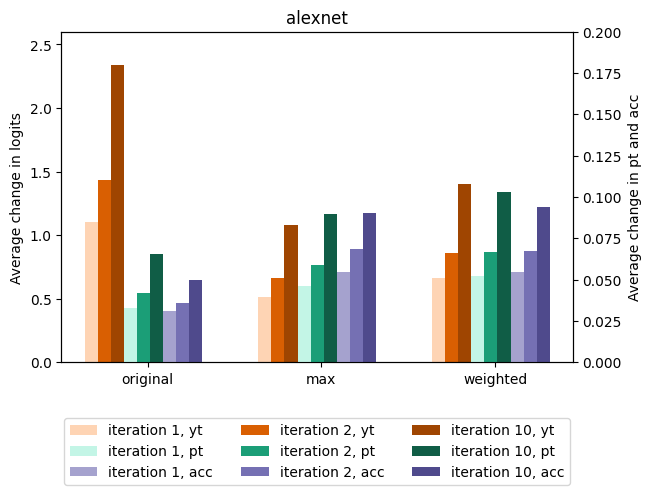

In [56]:
# Plots
import matplotlib.pyplot as plt

iter_numbers = [1,2,10]
model_name = "alexnet"

def plot_results(results_dict):
    measurements = {"iteration 1, yt": tuple([results_dict[p]["1"]['yt'] for p in perturbation_types]),
                    "iteration 2, yt": tuple([results_dict[p]["2"]['yt'] for p in perturbation_types]),
                    "iteration 10, yt": tuple([results_dict[p]["10"]['yt'] for p in perturbation_types]),
                    }

    measurements_2 = {
                    "iteration 1, pt":tuple([results_dict[p]["1"]['pt'] for p in perturbation_types]),
                    "iteration 2, pt":tuple([results_dict[p]["2"]['pt'] for p in perturbation_types]),
                    "iteration 10, pt":tuple([results_dict[p]["10"]['pt'] for p in perturbation_types]),
                    "iteration 1, acc":tuple([results_dict[p]["1"]['acc'] for p in perturbation_types]),
                    "iteration 2, acc":tuple([results_dict[p]["2"]['acc'] for p in perturbation_types]),
                    "iteration 10, acc":tuple([results_dict[p]["10"]['acc'] for p in perturbation_types]),
    }


    fig, axs = plt.subplots(len(model_names), layout="constrained")

    axs.set_title(model_name)
    width = 0.15
    multiplier = 0
    x = np.arange(len(perturbation_types))

    colormapping = {
                    "iteration 1, yt": "#fed4b4", #orange , ljus
                    "iteration 1, pt": "#c3f5e6", #grön, ljus
                    "iteration 1, acc": "#a5a2ce",  #lila, ljus
                    "iteration 2, yt": "#d95f02",
                    "iteration 2, pt": "#1b9e77",
                    "iteration 2, acc": "#7570b3",
                    "iteration 10, yt": "#9f4501",
                    "iteration 10, pt": "#105d46",
                    "iteration 10, acc": "#4f4a8c",

                    }

    for attribute, measurement in measurements.items():
          offset = width * multiplier + 0.6
          rects = axs.bar(2*x + offset, measurement, width, label=attribute, color=colormapping[attribute])
          multiplier += 1


    x_tickes = (p_type for p_type in perturbation_types)
    axs.set_xticks(2*x + width+1, x_tickes)
    axs.set_ylim(0,2.6)
    axs.set_ylabel("Average change in logits")

    # Create the twin axis
    axs2 = axs.twinx()
    multiplier = 0
    x = np.arange(len(perturbation_types))

    for attribute, measurement in measurements_2.items():
          offset = width * multiplier + 3*width +0.6
          rects = axs2.bar(2*x + offset, measurement, width, label=attribute, color=colormapping[attribute])
          multiplier += 1

    x_tickes = (p_type for p_type in perturbation_types)
    axs2.set_xticks(2*x + width+1.1, x_tickes)
    axs2.set_ylim(0,0.2)
    axs2.set_ylabel("Average change in pt and acc")

    order = [0, 3, 6, 1, 4, 7, 2, 5, 8]
    lines, labels = axs.get_legend_handles_labels()
    lines2, labels2 = axs2.get_legend_handles_labels()
    tot_lines = lines+lines2
    tot_labels = labels+labels2
    axs2.legend([tot_lines[i] for i in order], [tot_labels[i] for i in order], bbox_to_anchor =(0.5,-0.27), loc='center', ncols=3)

    plt.show()


plot_results(average_changes)

In [49]:
# Save results

for model in model_names:
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  filename = "results_"+model+"_"+str(n_batches)+"_"+timestamp+".json"
  results_folder = "/content/drive/MyDrive/Colab Notebooks/Deep learning advanced/Results_exp1"

  with open(results_folder+"/"+filename, "w") as results_file:
    json.dump(average_changes, results_file)




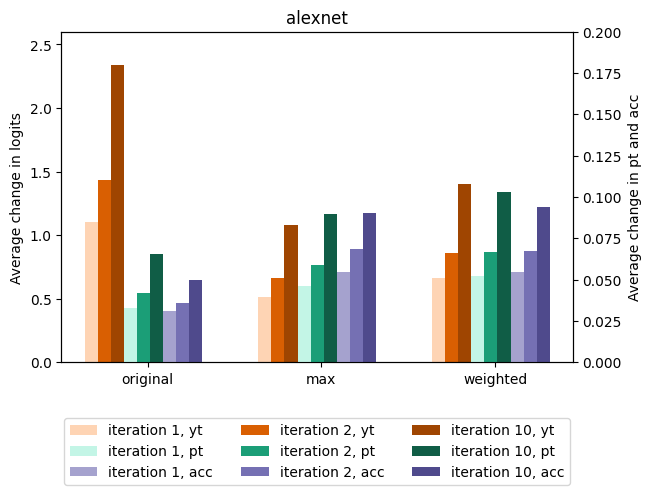

In [57]:
# Plot old results

saved_filename = results_folder+"/"+"results_alexnet_10_2023-11-14_17-50-31.json"
with open(saved_filename, 'r') as json_file:
    saved_results_dict = json.load(json_file)



plot_results(saved_results_dict)
